In [39]:
import cv2
import imageio
import json
import matplotlib.pyplot as plt
import numpy as np

# Suppresses scientific notation for small numbers in numpy arrays for readability
np.set_printoptions(suppress=True)

/tmp/ipykernel_27663/2801124690.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  rgb = imageio.imread(data_path)


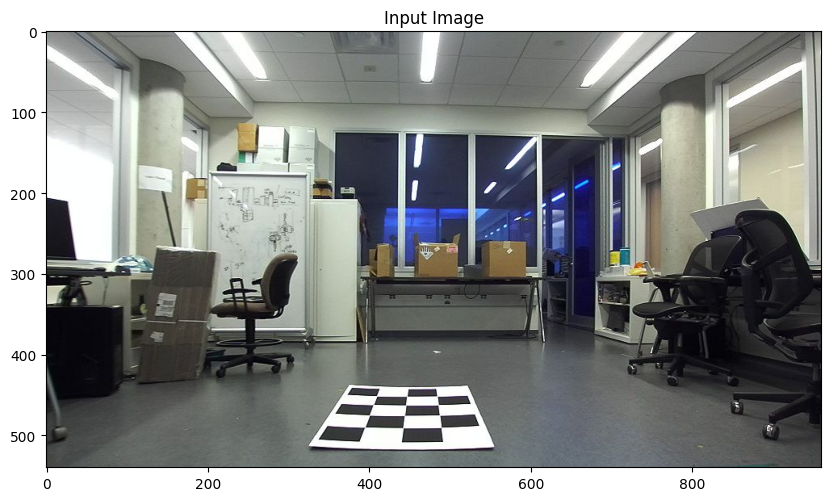

In [40]:
data_path = 'data/front_view_robot.png'
rgb = imageio.imread(data_path)
plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title('Input Image')
plt.show()

In [41]:
# From world to camera coordinates
camera_params_path = 'camera_params_robot.json'
camera_params = None
with open(camera_params_path, 'r') as fh:
    camera_params = json.load(fh)
print(camera_params)

{'baseline': 0.0, 'pitch': 0.0, 'roll': 0.0, 'yaw': -0.0, 'x': 0.0, 'y': 0.0, 'z': 1.5, 'fx': 560.1915283203125, 'fy': 560.1915283203125, 'cx': 490.475341796875, 'cy': 296.8459777832031}


In [42]:
# b = camera_params['baseline']

K = np.array([
    [camera_params['fx'], 0.0, camera_params['cx']],
    [0.0, camera_params['fy'], camera_params['cy']],
    [0.0, 0.0, 1.0]
]).astype(np.float32)

Kinv = np.linalg.inv(K)

# print(K.shape)

print('K = ', K)

print('Kinv = ', Kinv)

# theta_x (roll), theta_y (pitch), theta_z (yaw)
rotation_euler_angles = np.array([ camera_params['roll'], camera_params['pitch'], camera_params['yaw'] ])
# Rotation matrix R = Rx*Ry*Rz

print('rotation_euler_angles = ', rotation_euler_angles)

t = np.array([ camera_params['x'], camera_params['y'], camera_params['z'] ])

print('t = ', t)

K =  [[560.1915    0.      490.47534]
 [  0.      560.1915  296.84598]
 [  0.        0.        1.     ]]
Kinv =  [[ 0.0017851   0.         -0.8755494 ]
 [ 0.          0.0017851  -0.52990085]
 [ 0.          0.          1.        ]]
rotation_euler_angles =  [ 0.  0. -0.]
t =  [0.  0.  1.5]


In [43]:
# pnt_cam = H_c2v*H_v2r(t)*pnt_road
def rotation_mat(euler_angles):
    theta_x, theta_y, theta_z = euler_angles
    Rz = np.array([
        np.cos(theta_z), -np.sin(theta_z), 0.0,
        np.sin(theta_z), np.cos(theta_z), 0.0,
        0.0, 0.0, 1.0,
    ]).reshape(3, 3)
    Ry = np.array([
        np.cos(theta_y), 0.0, np.sin(theta_y),
        0.0, 1.0, 0.0,
        -np.sin(theta_y), 0.0, np.cos(theta_y),
    ]).reshape(3, 3)
    Rx = np.array([
        1.0, 0.0, 0.0,
        0.0, np.cos(theta_x), -np.sin(theta_x),
        0.0, np.sin(theta_x), np.cos(theta_x),
    ]).reshape(3, 3)
    return Rz @ Ry @ Rx

In [44]:
# From car coords to camera coords: R and t
R = rotation_mat(rotation_euler_angles)
print('R = ', R)

H = np.array([
    *R[0, :], t[0],
    *R[1, :], t[1],
    *R[2, :], t[2],
]).reshape(3, 4).astype(np.float32)

print('H = ', H)

# Since, the rotation matrix is symmetric, Rinv = R.T since R.R.T = I => R.t = Rinv
R_inv = np.linalg.pinv(R)
# print(R_inv)
t_inv = -t # a' = a + t => a = a' - t

R =  [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
H =  [[1.  0.  0.  0. ]
 [0.  1.  0.  0. ]
 [0.  0.  1.  1.5]]


In [45]:
# From car coords to camera coords
H_v2c = np.array([
    *R_inv[0, :], t_inv[0],
    *R_inv[1, :], t_inv[1],
    *R_inv[2, :], t_inv[2]
]).reshape(3, 4).astype(np.float32)
print(H_v2c.shape)

'''
    (1) Rotate around z-axis
    (2) Rotate around x-axis
    
    Now, the coordinate system of the road/car is aligned with the one of camera
'''

theta = np.pi / 2
Rz = np.array([
    [ np.cos(theta), -np.sin(theta), 0.0 ],
    [ np.sin(theta), np.cos(theta), 0.0 ],
    [ 0.0, 0.0, 1.0 ]
])

Rx = np.array([
    [ 1.0, 0.0, 0.0 ],
    [ 0.0, np.cos(theta), -np.sin(theta) ],
    [ 0.0, np.sin(theta), np.cos(theta) ]
])

P = Rx @ Rz
print(P)

H = P @ H_v2c
print(H.shape)

(3, 4)
[[ 0. -1.  0.]
 [ 0.  0. -1.]
 [ 1.  0.  0.]]
(3, 4)


/tmp/ipykernel_27663/3651615871.py:30: RuntimeWarning: invalid value encountered in cast
  img_pnt = img_pnt.astype(np.int32)


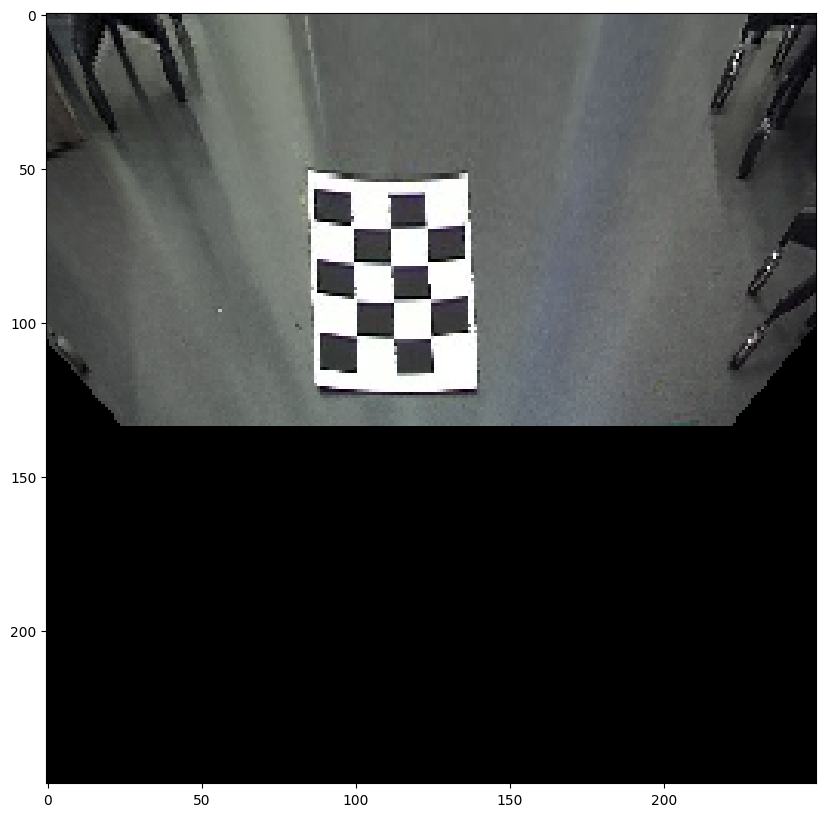

In [46]:
'''
    Procedure:
        (1) Define the road plane on which to project into bev
        (2) Project from 3D to 2D ([u, v, 1].T = K . Hr2c . [Xr, Yr, Zr=0, 1].T) (this is our projection matrix P)
        (3) Rotate the axes so they match (from car to camera)
        (4) Get rgb intensity of pixel value and map 1-to-1 on the road plane (one could bilinearly sample for better results)
'''

# Desing choices:
# (1) defined by the engineer
road_side = 250
# (2) meters/pxl (obtained from calibration)
scale = 0.030

# Define our road plane (wrt vehicle): [X, -Y, Z=0, 1], given coordinate system of the vehicle (refer to diagram at begining)
road_img = np.zeros(shape=(road_side, road_side, 3)).astype(np.int32)
half = road_side // 2

# Begin loop for generating BEV image
for row in range(-half, half):
    for col in range(0, road_side):
        # Convert road plane coordinates to meters
        road_pnt = np.array([col * scale, -row * scale, 0, 1]).T
        
        # Transform the 3D point from the road plane to the camera image's pixel coordinates
        img_pnt = K @ H @ road_pnt
        # Normalize the homogeneous coordinates
        img_pnt = img_pnt // (img_pnt[-1] + 1e-8)
        # Convert to integer pixel coordinates
        img_pnt = img_pnt.astype(np.int32)
        
        # Ensure rgb_val only contains RGB components
        if img_pnt[0] > 0 and img_pnt[0] < rgb.shape[1] and img_pnt[1] > 0 and img_pnt[1] < rgb.shape[0]:
            rgb_val = rgb[img_pnt[1], img_pnt[0], :3]  # Slicing to ensure only RGB components are selected
        else:
            rgb_val = np.zeros(3)  # Fallback to a black color if the point is outside the image bounds
        
        # Assign the RGB value to the corresponding location in the BEV image
        road_img[row + half][col] = rgb_val

rotated_img = np.rot90(road_img)
plt.figure(figsize=(10, 10))
plt.imshow(rotated_img)
plt.show()
